In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence
import h5py
import numpy as np
import matplotlib.pyplot as plt
import copy

## Dataset Definition

In [29]:
class AudioFeaturesDataset(Dataset):
    def __init__(self, h5_file, split_type='train'):
        self.h5_file = h5_file
        self.data = []
        self.labels = []
        self.label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
        
        with h5py.File(h5_file, 'r') as file:
            for key in file.keys():
                if file[key].attrs['split'] == split_type:
                    features = file[key]['mfcc_features_normalized'][:]
                    label = file[key].attrs['label']
                    self.data.append(torch.tensor(features, dtype=torch.float))
                    self.labels.append(self.label_mapping[label])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx], dtype=torch.long)

# We need this because our video clips length are different
def collate_fn(batch):
    features, labels = zip(*batch)
    # Pad the sequences to have the same length
    features_padded = pad_sequence(features, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return features_padded, labels

## Model Definition

In [33]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.gru =  nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        # out, _ = self.gru(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

In [4]:
def validate(model, data_loader, criterion, device):
    model.eval()  
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    return avg_loss, accuracy


## Execution

In [39]:
batch_size = 32
dataset = AudioFeaturesDataset(r'output_h5/normalized_mfccs.h5')

dataset_train = AudioFeaturesDataset('output_h5/normalized_mfccs.h5', 'train')
dataset_val = AudioFeaturesDataset('output_h5/normalized_mfccs.h5', 'validate')
dataset_test = AudioFeaturesDataset('output_h5/normalized_mfccs.h5', 'test')

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [43]:
############################################
# Params
num_epochs = 50
learning_rate = 0.001
hidden_size = 1024
num_layers = 2


patience = 5


# Speed Params
num_workers = 0

############################################

# Model instantiation
model = LSTMClassifier(input_dim=20, hidden_dim=hidden_size, output_dim=3, num_layers=num_layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.1, verbose=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifier(
  (lstm): LSTM(20, 1024, num_layers=2, batch_first=True)
  (gru): GRU(20, 1024, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [44]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_weights = copy.deepcopy(model.state_dict())  
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        # print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving model ...")
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        # Save model (optional)
        torch.save(model.state_dict(), 'best_model_LSTM.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/50], Training Loss: 1.0997, Validation Loss: 1.0990, Validation Accuracy: 0.3322
Epoch [2/50], Training Loss: 1.1194, Validation Loss: 1.1013, Validation Accuracy: 0.3409
Epoch [3/50], Training Loss: 1.1017, Validation Loss: 1.1001, Validation Accuracy: 0.3309
Epoch [4/50], Training Loss: 1.1003, Validation Loss: 1.0989, Validation Accuracy: 0.3482
Epoch [5/50], Training Loss: 1.0997, Validation Loss: 1.0993, Validation Accuracy: 0.3229
Epoch [6/50], Training Loss: 1.0995, Validation Loss: 1.1005, Validation Accuracy: 0.3162


KeyboardInterrupt: 

## Plotting training vs validation losses

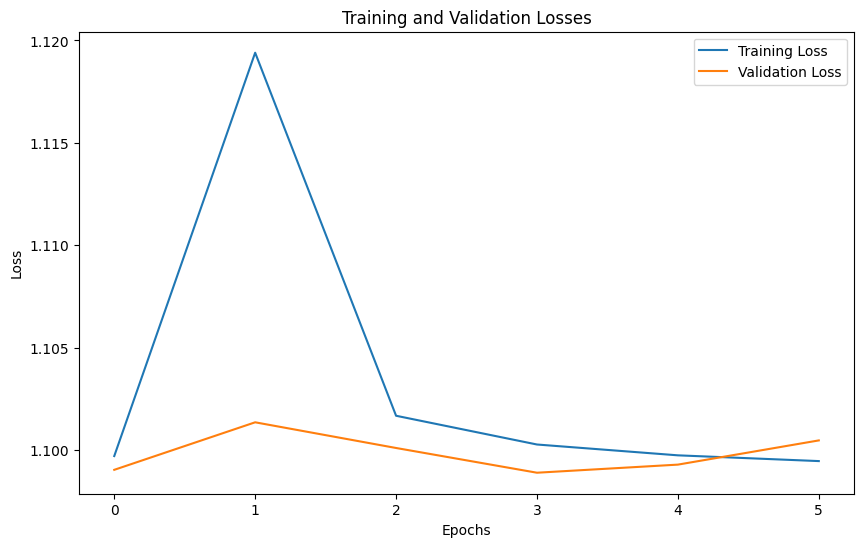

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Testing model

In [ ]:
model.load_state_dict(best_model_weights)
# model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f'Lowest validation loss: {best_val_loss}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Lowest validation loss: 0.9709818751915641, Test Loss: 1.0162, Test Accuracy: 0.5428
